In [1]:
import lhapdf
#import ROOT
import math
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
plt.rcParams['text.usetex'] = True
## Getting a PDF member object
p_cteq6 = lhapdf.mkPDF("cteq6l1", 0)
p_cteq6 = lhapdf.mkPDF("cteq6l1/0")
JAM20 = lhapdf.mkPDF("JAM20-SIDIS_FF_pion_nlo", 0)

LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/cteq6l1/cteq6l1_0000.dat
cteq6l1 PDF set, member #0, version 4; LHAPDF ID = 10042
LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/cteq6l1/cteq6l1_0000.dat
cteq6l1 PDF set, member #0, version 4; LHAPDF ID = 10042
LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/JAM20-SIDIS_FF_pion_nlo/JAM20-SIDIS_FF_pion_nlo_0000.dat
JAM20-SIDIS_FF_pion_nlo PDF set, member #0, version 2


[ 2.77098590e-03 -5.38378095e-02  3.89198499e+00  1.63554771e+00]


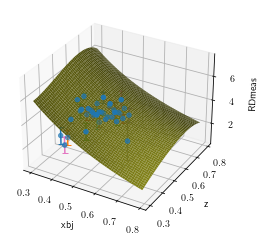

In [2]:
from scipy.optimize import minimize
import scipy.integrate as integr
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
with open('yield_ratio_xz_combined_weighted.json') as j_RD:
    RDxz = json.load(j_RD)
zs = []
xs = []
RDs = []
RDs_error = []

Q2 = 5.5
Q = math.sqrt(5.5)

for key_xbj,xbj_value in RDxz["5.500000"].items():
    xbj = float(key_xbj) 
    for key_z,z_value in xbj_value.items():
        xs.append(xbj)
        z_hadron = float(key_z)
        zs.append(z_hadron)
        RD=float(z_value["value_ratio"])
        RD_error = float(z_value["error_ratio"])
        RDs.append(float(z_value["value_ratio"]))
        RDs_error.append(float(z_value["error_ratio"]))
        ax.plot([xbj,xbj],[z_hadron,z_hadron],[RD+RD_error,RD-RD_error],marker="_")
        
ax.scatter(xs,zs,RDs)
ax.set_xlabel("xbj")
ax.set_ylabel("z")
ax.set_zlabel("RDmeas")




#def CSVx(xbj,paramsCSV):
#    c = paramsCSV[2]
#    d = paramsCSV[3]
#    return (1-xbj)**c*xbj**d
#def Dz(a,b,zs):
   # delta_z = z_had**a*(1+z_had)**b
   # return (1-delta_z)/(1+delta_z)
#def RDmeas_CSV(params,z_had,xbj):
#    Q = 2
#    Bx = 5*(p_cteq6.xfxQ(-2,xbj,Q)+p_cteq6.xfxQ(-1,xbj,Q))/(p_cteq6.xfxQ(1,xbj,Q)+p_cteq6.xfxQ(2,xbj,Q))
#    Ax = -4/(3*(p_cteq6.xfxQ(2,xbj,Q)+p_cteq6.xfxQ(1,xbj,Q)))
#    return (Bx-Ax*CSVx)/Dz-2.5
def RDmeas_CSV(Q,z_had,a,b,xbj,c,d):
    #delta_z = a+b*z_had
    #delta_z = a+b*z_had/(1+z_had)
    #delta_z = z_had**a*(1-z_had)**b
    delta_z = z_had**a*(1+z_had)**b
    Dz = (1-delta_z)/(1+delta_z)
    CSVx = (1-xbj)**c*xbj**d
    B_NS = 5*(p_cteq6.xfxQ(-2,xbj,Q)+p_cteq6.xfxQ(-1,xbj,Q))/(p_cteq6.xfxQ(1,xbj,Q)+p_cteq6.xfxQ(2,xbj,Q))
    B_sz = (JAM20.xfxQ(3,z_had,Q)+JAM20.xfxQ(-3,z_had,Q))/JAM20.xfxQ(2,z_had,Q)/(1+JAM20.xfxQ(-2,z_had,Q)/JAM20.xfxQ(2,z_had,Q)) 
    Bx = B_sz*(p_cteq6.xfxQ(3,xbj,Q)+p_cteq6.xfxQ(-3,xbj,Q))/(p_cteq6.xfxQ(1,xbj,Q)+p_cteq6.xfxQ(2,xbj,Q))
    #Bx = 5*(p_cteq6.xfxQ(-2,xbj,Q)+p_cteq6.xfxQ(-1,xbj,Q))/(p_cteq6.xfxQ(1,xbj,Q)+p_cteq6.xfxQ(2,xbj,Q))
    Ax = -4/(3*(p_cteq6.xfxQ(2,xbj,Q)+p_cteq6.xfxQ(1,xbj,Q)))
    return (Bx-Ax*CSVx)/Dz-2.5

def CSV_Constr_fun(params):
    integral = integr.quad( CSVx, 0, 1, args=(params))
    return integral

def least_squares_scipy(params,Q,xs,zs,RD,RD_error):
    least_square = 0
    #Q = math.sqrt(5.5)
    ai = params[0]
    bi = params[1]
    ci = params[2]
    di = params[3]
    for i in range(len(xs)):
        least_square += (RDs[i]-RDmeas_CSV(Q,zs[i],ai,bi,xs[i],ci,di)) ** 2 / RD_error[i]**2
    return least_square
#print(len(xs))
#print(len(zs))
#print(len(RDs))
#print(len(RDs_error))

res1 = minimize(least_squares_scipy,x0 = [0.7,-0.6,1.3,0],args = (Q,xs,zs,RDs,RDs_error))
#,constraints = cons)
parameters1 = res1.x
print(parameters1)
a_scipy = parameters1[0]
b_scipy = parameters1[1]
c_scipy = parameters1[2]
d_scipy = parameters1[3]

x = np.arange(0.3,0.8,0.01)
y = np.arange(0.3,0.8,0.01)
#x = np.array(xs)
#y = np.array(zs)
fit_RDmeas=[]
for xbj in x:
    fit_RDmeas_zi = []
    for zi in y:
        #fit_RDmeas_zi.append()
        fit_RDmeas.append(RDmeas_CSV(Q,zi,a_scipy,b_scipy,xbj,c_scipy,d_scipy))
X,Y = np.meshgrid(x,y)
Z = np.reshape(fit_RDmeas,X.shape)
ax.plot_surface(X,Y,Z)
#,rstride=1,cstride=1,cmap=plt.cm.jet,linewidth=0,antialiased=False)

##with constraints
#cons = {'type': 'eq','fun': CSV_Constr_fun}
#res2 = minimize(least_squares_Q2,x0 = [0.7,-0.6,1.3,0],args = (Q,xs,zs,RDs,RDs_error),constraints = cons )
#parameters2 = res2.x
#print(parameters2)
#a2 = parameters2[0]
#b2 = parameters2[1]
#c2 = parameters2[2]
#d2 = parameters2[3]
#RDmeas_fit2 = RDmeas_CSV()

0.0027709858970623525
-0.05383780946276112
3.8919849868104115
1.6355477066475554
5.5


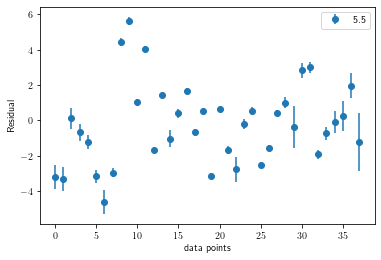

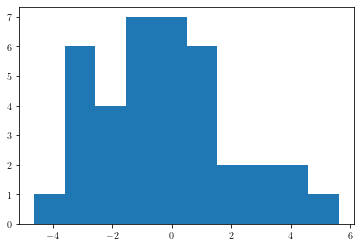

In [3]:
i_scipy = 0
zs_scipy = []
Residual_scipy = []
Residual_count_scipy = []
Residual_error_scipy = []
#a_scipy = parameters1[0]
#b_scipy = parameters1[1]
#c_scipy = parameters1[2]
#d_scipy = parameters1[3]
print(a_scipy)
print(b_scipy)
print(c_scipy)
print(d_scipy)
print(Q2)
for key_xbj,xbj_value in RDxz["5.500000"].items():
    xbj = float(key_xbj) 
    for key_z,z_value in xbj_value.items():
        xs.append(xbj)
        z_hadron = float(key_z)
        zs.append(z_hadron)
        RD=float(z_value["value_ratio"])
        RD_error = float(z_value["error_ratio"])
        Residual_error_scipy.append(RD_error)
        RDmeas_CSV_fit = RDmeas_CSV(math.sqrt(Q2),z_hadron,a_scipy,b_scipy,xbj,c_scipy,d_scipy)
        Residual_scipy.append((RD-RDmeas_CSV_fit)/RD_error)
        Residual_count_scipy.append(i_scipy)
        i_scipy+=1
  #plt.plot(Residual_count,Residual,"P",label=Qs[i_Q2])
plt.errorbar(Residual_count_scipy,Residual_scipy,Residual_error_scipy,fmt='o',label = '5.5')
plt.xlabel("data points")
plt.ylabel("Residual")
plt.legend()
fig,ax = plt.subplots()
plt.hist(Residual_scipy,10)
plt.show()